<a href="https://colab.research.google.com/github/gouthamkallempudi/Signals_Detection/blob/master/DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from keras.layers.core import Layer
import tensorflow as tf
import numpy as np
from keras.layers import (Activation, Dense, Dropout, Flatten,
                          Lambda, MaxPooling2D)
from keras.layers.convolutional import Conv2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, model_from_json
from keras.regularizers import l2
from keras.utils import np_utils


import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from imageio import imread 
from skimage.transform import resize
import pandas as pd
import glob

In [0]:
class SpatialTransformer(Layer):
 

    def __init__(self,
                 localization_net,
                 output_size,
                 **kwargs):
        self.locnet = localization_net
        self.output_size = output_size
        super(SpatialTransformer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.locnet.build(input_shape)
        self.trainable_weights = self.locnet.trainable_weights
        #self.constraints = self.locnet.constraints

    def compute_output_shape(self, input_shape):
        output_size = self.output_size
        return (None,
                int(output_size[0]),
                int(output_size[1]),
                int(input_shape[-1]))

    def call(self, X, mask=None):
        affine_transformation = self.locnet.call(X)
        output = self._transform(affine_transformation, X, self.output_size)
        return output

    def _repeat(self, x, num_repeats):
        ones = tf.ones((1, num_repeats), dtype='int32')
        x = tf.reshape(x, shape=(-1,1))
        x = tf.matmul(x, ones)
        return tf.reshape(x, [-1])

    def _interpolate(self, image, x, y, output_size):
        batch_size = tf.shape(image)[0]
        height = tf.shape(image)[1]
        width = tf.shape(image)[2]
        num_channels = tf.shape(image)[3]

        x = tf.cast(x , dtype='float32')
        y = tf.cast(y , dtype='float32')

        height_float = tf.cast(height, dtype='float32')
        width_float = tf.cast(width, dtype='float32')

        output_height = output_size[0]
        output_width  = output_size[1]

        x = .5*(x + 1.0)*(width_float)
        y = .5*(y + 1.0)*(height_float)

        x0 = tf.cast(tf.floor(x), 'int32')
        x1 = x0 + 1
        y0 = tf.cast(tf.floor(y), 'int32')
        y1 = y0 + 1

        max_y = tf.cast(height - 1, dtype='int32')
        max_x = tf.cast(width - 1,  dtype='int32')
        zero = tf.zeros([], dtype='int32')

        x0 = tf.clip_by_value(x0, zero, max_x)
        x1 = tf.clip_by_value(x1, zero, max_x)
        y0 = tf.clip_by_value(y0, zero, max_y)
        y1 = tf.clip_by_value(y1, zero, max_y)

        flat_image_dimensions = width*height
        pixels_batch = tf.range(batch_size)*flat_image_dimensions
        flat_output_dimensions = output_height*output_width
        base = self._repeat(pixels_batch, flat_output_dimensions)
        base_y0 = base + y0*width
        base_y1 = base + y1*width
        indices_a = base_y0 + x0
        indices_b = base_y1 + x0
        indices_c = base_y0 + x1
        indices_d = base_y1 + x1

        flat_image = tf.reshape(image, shape=(-1, num_channels))
        flat_image = tf.cast(flat_image, dtype='float32')
        pixel_values_a = tf.gather(flat_image, indices_a)
        pixel_values_b = tf.gather(flat_image, indices_b)
        pixel_values_c = tf.gather(flat_image, indices_c)
        pixel_values_d = tf.gather(flat_image, indices_d)

        x0 = tf.cast(x0, 'float32')
        x1 = tf.cast(x1, 'float32')
        y0 = tf.cast(y0, 'float32')
        y1 = tf.cast(y1, 'float32')

        area_a = tf.expand_dims(((x1 - x) * (y1 - y)), 1)
        area_b = tf.expand_dims(((x1 - x) * (y - y0)), 1)
        area_c = tf.expand_dims(((x - x0) * (y1 - y)), 1)
        area_d = tf.expand_dims(((x - x0) * (y - y0)), 1)
        output = tf.add_n([area_a*pixel_values_a,
                           area_b*pixel_values_b,
                           area_c*pixel_values_c,
                           area_d*pixel_values_d])
        return output

    def _meshgrid(self, height, width):
        x_linspace = tf.linspace(-1., 1., width)
        y_linspace = tf.linspace(-1., 1., height)
        x_coordinates, y_coordinates = tf.meshgrid(x_linspace, y_linspace)
        x_coordinates = tf.reshape(x_coordinates, shape=(1, -1))
        y_coordinates = tf.reshape(y_coordinates, shape=(1, -1))
        ones = tf.ones_like(x_coordinates)
        indices_grid = tf.concat([x_coordinates, y_coordinates, ones], 0)
        return indices_grid

    def _transform(self, affine_transformation, input_shape, output_size):
        batch_size = tf.shape(input_shape)[0]
        height = tf.shape(input_shape)[1]
        width = tf.shape(input_shape)[2]
        num_channels = tf.shape(input_shape)[3]

        affine_transformation = tf.reshape(affine_transformation, shape=(batch_size,2,3))

        affine_transformation = tf.reshape(affine_transformation, (-1, 2, 3))
        affine_transformation = tf.cast(affine_transformation, 'float32')

        width = tf.cast(width, dtype='float32')
        height = tf.cast(height, dtype='float32')
        output_height = output_size[0]
        output_width = output_size[1]
        indices_grid = self._meshgrid(output_height, output_width)
        indices_grid = tf.expand_dims(indices_grid, 0)
        indices_grid = tf.reshape(indices_grid, [-1]) # flatten?
        indices_grid = tf.tile(indices_grid, tf.stack([batch_size]))
        indices_grid = tf.reshape(indices_grid, tf.stack([batch_size, 3, -1]))

        # transformed_grid = tf.batch_matmul(affine_transformation, indices_grid)
        transformed_grid = tf.matmul(affine_transformation, indices_grid)
        x_s = tf.slice(transformed_grid, [0, 0, 0], [-1, 1, -1])
        y_s = tf.slice(transformed_grid, [0, 1, 0], [-1, 1, -1])
        x_s_flatten = tf.reshape(x_s, [-1])
        y_s_flatten = tf.reshape(y_s, [-1])

        transformed_image = self._interpolate(input_shape,
                                                x_s_flatten,
                                                y_s_flatten,
                                                output_size)

        transformed_image = tf.reshape(transformed_image, shape=(batch_size,
                                                                output_height,
                                                                output_width,
                                                                num_channels))
        return transformed_image

In [0]:
def locnet():
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    W = np.zeros((64, 6), dtype='float32')
    weights = [W, b.flatten()]
    locnet = Sequential()

    locnet.add(Conv2D(16, (7, 7), padding='valid', input_shape=(32, 32, 3)))
    locnet.add(MaxPooling2D(pool_size=(2, 2)))
    locnet.add(Conv2D(32, (5, 5), padding='valid'))
    locnet.add(MaxPooling2D(pool_size=(2, 2)))
    locnet.add(Conv2D(64, (3, 3), padding='valid'))
    locnet.add(MaxPooling2D(pool_size=(2, 2)))

    locnet.add(Flatten())
    locnet.add(Dense(128))
    locnet.add(Activation('elu'))
    locnet.add(Dense(64))
    locnet.add(Activation('elu'))
    locnet.add(Dense(6, weights=weights))

    return locnet

In [0]:
def conv_model(input_shape=(32, 32, 3)):
    model = Sequential()
    model.add(Lambda(
        lambda x: x/127.5 - 1.,
        input_shape=(32, 32, 3),
        output_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(10, (1, 1), padding='same', kernel_regularizer=l2(0.05)))
    model.add(LeakyReLU(alpha=0.5))
    model.add(BatchNormalization())
    model.add(Conv2D(3, (1, 1), padding='same', kernel_regularizer=l2(0.05)))
    model.add(LeakyReLU(alpha=0.5))
    model.add(BatchNormalization())
    model.add(SpatialTransformer(localization_net=locnet(),
                                 output_size=(32, 32)))
    model.add(Conv2D(16, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.05)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.05)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.05)))
    model.add(BatchNormalization())
    model.add(Conv2D(96, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.05)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.05)))
    model.add(BatchNormalization())
    model.add(Conv2D(192, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.05)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.05)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.05)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.05)))
    model.add(MaxPooling2D(pool_size=(8, 8)))
    model.add(Flatten())
    model.add(Dropout(0.6))
    model.add(Dense(43, activation="softmax"))
    return model

In [0]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from scipy.misc import imread, imresize
import pandas as pd
import glob

model = conv_model()
model.load_weights("gdrive/My Drive/Traffic-Signal/output/weights.hdf5")

In [62]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_6 (Lambda)            (None, 32, 32, 3)         0         
_________________________________________________________________
batch_normalization_48 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 32, 32, 10)        40        
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 32, 32, 10)        0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 32, 32, 10)        40        
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 32, 32, 3)         33        
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 32, 32, 3)         0         
__________

In [0]:
layer_outputs = [layer.output for layer in model.layers[:12]] 

In [0]:
from keras import models
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

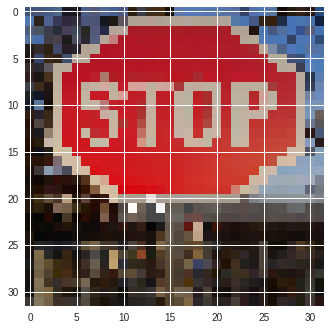

(1, 32, 32, 3)


In [65]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
img_path = 'gdrive/My Drive/Traffic-Signal/signs/stop.jpg'
img = image.load_img(img_path, target_size=(32, 32))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)

In [0]:
activations = activation_model.predict(img_tensor) 

In [67]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 32, 32, 3)


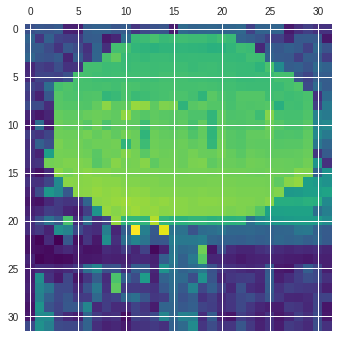

In [68]:
plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')

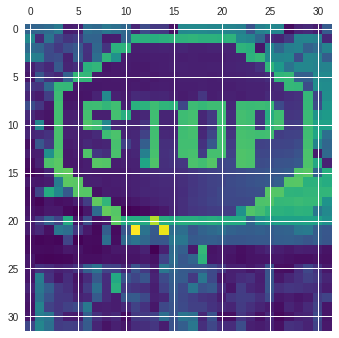

In [69]:
plt.matshow(first_layer_activation[0, :, :,1], cmap='viridis')

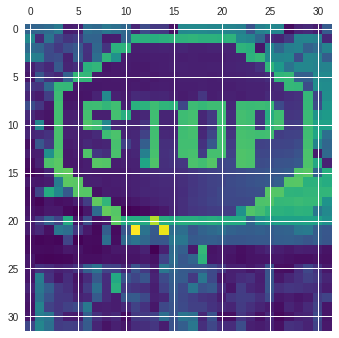

In [70]:
plt.matshow(first_layer_activation[0, :, :,1], cmap='viridis')

In [0]:
from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor) 
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index])
            activation_index += 1

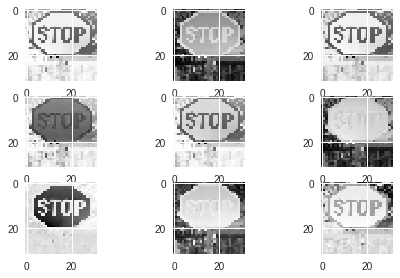

In [72]:
display_activation(activations,3,3,3)


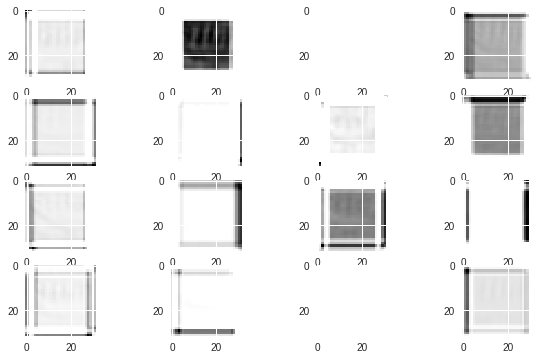

In [73]:
display_activation(activations,4,4,14)

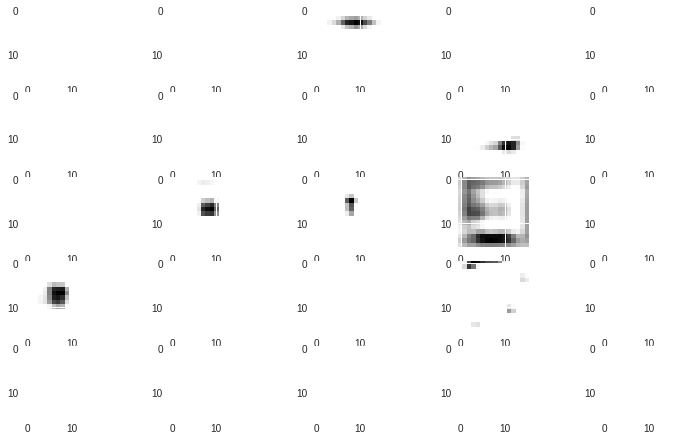

In [74]:
display_activation(activations,5,5,22)

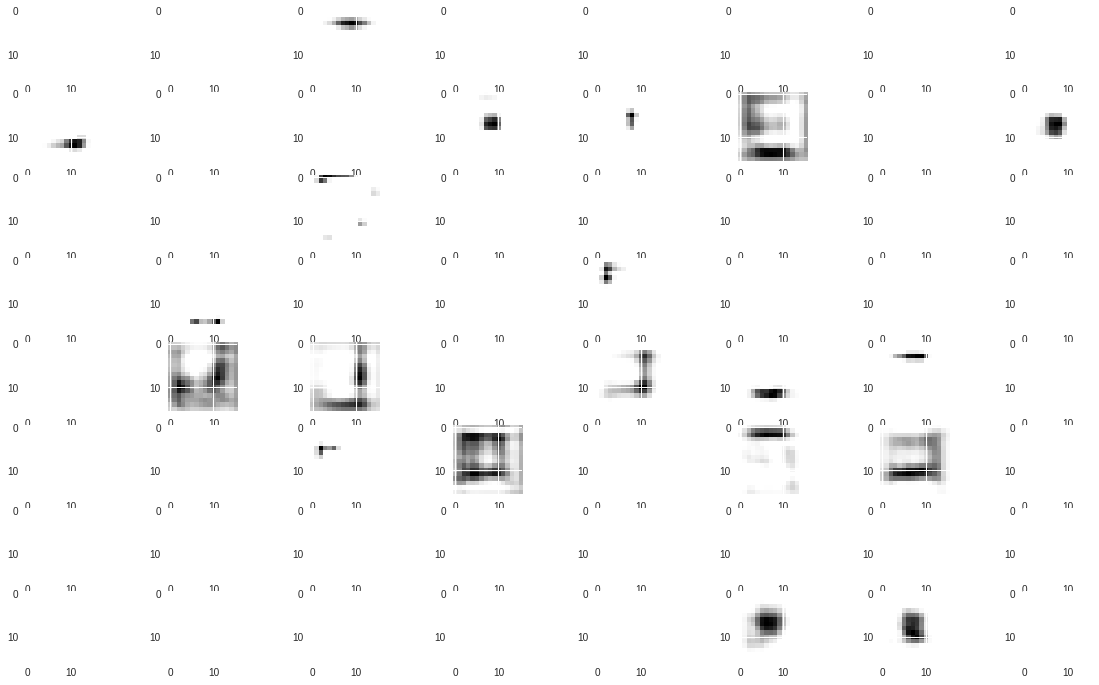

In [75]:
display_activation(activations,8,8,22)

In [0]:
model = conv_model()
model.load_weights("gdrive/My Drive/Traffic-Signal/output/weights.hdf5")
SignNames = pd.read_csv('gdrive/My Drive/Traffic-Signal/input/signnames.csv')

In [0]:
def find_image(image_names):
  X_sample_original = []
  X_sample_new = []
  for image_name in image_names:
      img1 = imread(image_name)
      img = imresize(img1, (32, 32))
      img1 = imresize(img1 , (128,128))
      X_sample_new.append(img)
      X_sample_original.append(img1)

  X_sample_new = np.array(X_sample_new)
  ## examine the results
  gs1 = gridspec.GridSpec(4, 3)
  gs1.update(wspace=0.005, hspace=0.01) # set the spacing between axes.
  plt.figure(figsize=(12,12))
  #for i in range(7):
  #    ax1 = plt.subplot(gs1[i])
  #    ax1.set_xticklabels([])
  #    ax1.set_yticklabels([])
  #    ax1.set_aspect('equal')
  #    plt.subplot(4,3,i+1)
  #    plt.imshow(X_sample_new[i])
  #    plt.axis('off')

  y_prob = model.predict(X_sample_new)
  for i in range(1):
    if max(y_prob[i]) > 0.08 :
      plt.figure(figsize = (5,1.5))
      gs = gridspec.GridSpec(1, 2, width_ratios=[2,3])
      plt.subplot(gs[0])
      plt.imshow(X_sample_original[i])
      plt.axis('off')
      plt.subplot(gs[1])
      top5_ind = np.argpartition(y_prob[i], -5)[-5:]
      plt.barh(6-np.arange(5),y_prob[i][top5_ind], align='center')
      for i_label in range(5):
          plt.text(y_prob[i][top5_ind][i_label]+.02,6-i_label-.25,
              SignNames[SignNames['ClassId'] == top5_ind[i_label]]['SignName'].values[0])
      plt.axis('off')
      plt.show()
    else:
      plt.figure(figsize = (5,1.5))
      gs = gridspec.GridSpec(1, 2, width_ratios=[2,3])
      plt.subplot(gs[0])
      plt.imshow(X_sample_original[i])
      plt.axis('off')
      plt.subplot(gs[1]) 
      plt.text(0, 0.5, "Not a Traffic Signal", fontsize=15)
      plt.axis('off')
      plt.show()



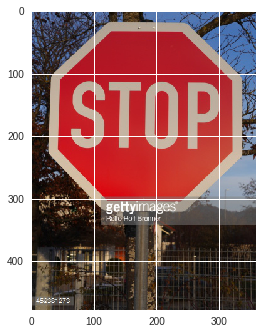

In [99]:
image = mpimg.imread('gdrive/My Drive/Traffic-Signal/signs/stop.jpg')
plt.imshow(image)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


<Figure size 864x864 with 0 Axes>

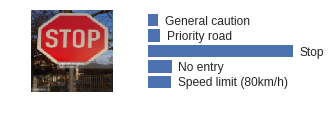

In [100]:
image_names = glob.glob('gdrive/My Drive/Traffic-Signal/signs/stop.jpg')
find_image(image_names)

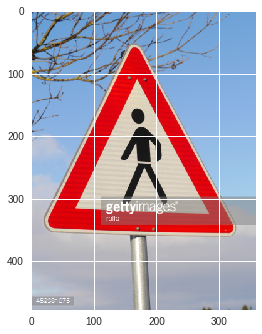

In [101]:
image = mpimg.imread('gdrive/My Drive/Traffic-Signal/signs/pedastrains.jpg')
plt.imshow(image)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


<Figure size 864x864 with 0 Axes>

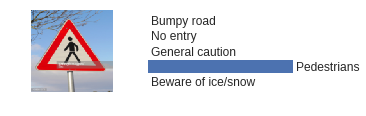

In [102]:
image_names = glob.glob('gdrive/My Drive/Traffic-Signal/signs/pedastrains.jpg')
find_image(image_names)

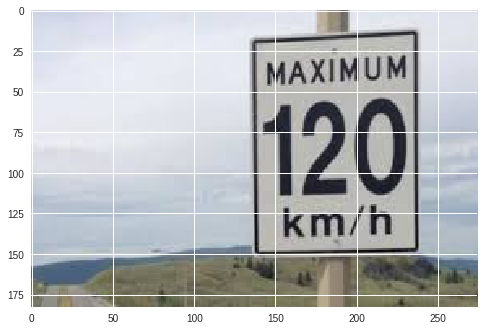

In [106]:
image = mpimg.imread('gdrive/My Drive/Traffic-Signal/signs/120.jpg')
plt.imshow(image)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


<Figure size 864x864 with 0 Axes>

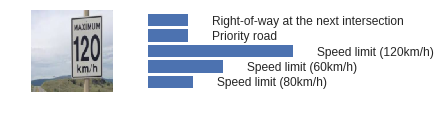

In [105]:
image_names = glob.glob('gdrive/My Drive/Traffic-Signal/signs/120.jpg')
find_image(image_names)

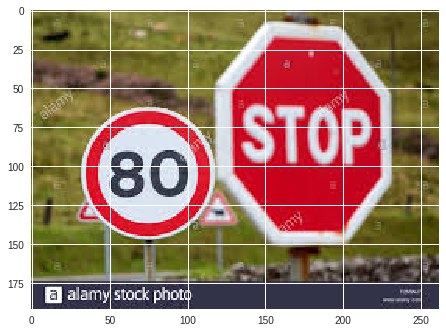

In [107]:
image = mpimg.imread('gdrive/My Drive/Traffic-Signal/signs/dual.jpg')
plt.imshow(image)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


<Figure size 864x864 with 0 Axes>

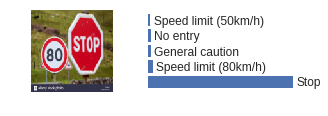

In [109]:
image_names = glob.glob('gdrive/My Drive/Traffic-Signal/signs/dual.jpg')
find_image(image_names)

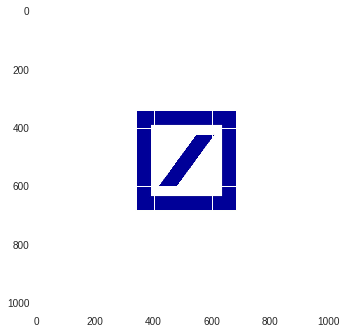

In [110]:
image = mpimg.imread('gdrive/My Drive/Traffic-Signal/signs/db.jpg')
plt.imshow(image)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


<Figure size 864x864 with 0 Axes>

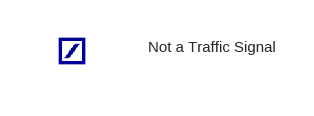

In [111]:
image_names = glob.glob('gdrive/My Drive/Traffic-Signal/signs/db.jpg')
find_image(image_names)